Code for **"Inpainting"** figures.

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.optim
import torch.nn as nn
from torch.autograd import Variable
from skimage.measure import compare_psnr
import utils
from model import create_model
import pickle

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True

dtype = torch.cuda.FloatTensor

# Load image and mask

In [2]:
# Amphithether
img_path  = 'data/inpainting/amphitheatre.jpg'
mask_path = 'data/inpainting/amphitheatre_mask.jpg'

img_pil = utils.get_image(img_path)
img_mask_pil = utils.get_image(mask_path)

### Center crop image and mask

In [3]:
# Make image and mask dividebly by a given number.
dim_div_by = 64

img_mask_pil = utils.crop_image(img_mask_pil, dim_div_by)
img_pil      = utils.crop_image(img_pil, dim_div_by)

img_np      = utils.pil_to_np(img_pil)
img_mask_np = utils.pil_to_np(img_mask_pil)

### Visualize

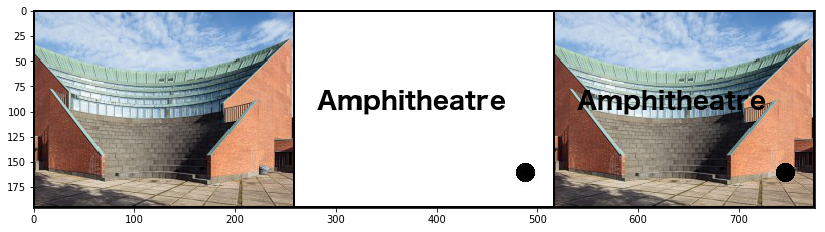

In [4]:
img_mask_var = utils.np_to_var(img_mask_np).type(dtype)

utils.plot_image_grid([img_np, img_mask_np, img_mask_np * img_np], 3, 11);

# Setup

In [5]:
pad = 'zero'
OPTIMIZER = 'adam'

INPUT = 'noise'
input_depth = 32
LR = 0.01 
num_iter = 6001
param_noise = False
show_every = 500
figsize = 10

In [6]:
net = create_model(downsample_channels = [128, 128, 128, 128, 128],
                   upsample_channels = [128, 128, 128, 128, 128],
                   skip_channels = [64, 64, 64, 64, 64],
                   input_channel_size = input_depth,
                   output_channel_size = img_np.shape[0],
                   upsample_mode='nearest',
                   need1x1=False,
                   padding_type=pad, 
                   activation_function=nn.LeakyReLU(0.2, inplace=True)
                ).type(dtype)

net = net.type(dtype)
net_input = utils.get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

layer 0
layer 1
layer 2
layer 3
layer 4


In [7]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

Number of params: 2513731


# Main loop

In [8]:
# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = utils.np_to_var(img_np).type(dtype)
mask_var = utils.np_to_var(img_mask_np).type(dtype)

i = 0

psnr_history = []
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n.data += n.data.clone().normal_()*n.data.std()/50
    
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
    
    psrn = compare_psnr(utils.var_to_np(out), img_np)
    psnr_history.append(psrn)
    
    print ('Iteration %05d    Loss %f   PSNR %.3f' % (i, total_loss.data[0], psrn), '\r', end='')
    if  i % show_every == 0:
        out_np = utils.var_to_np(out)
        utils.plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

Starting optimization with ADAM


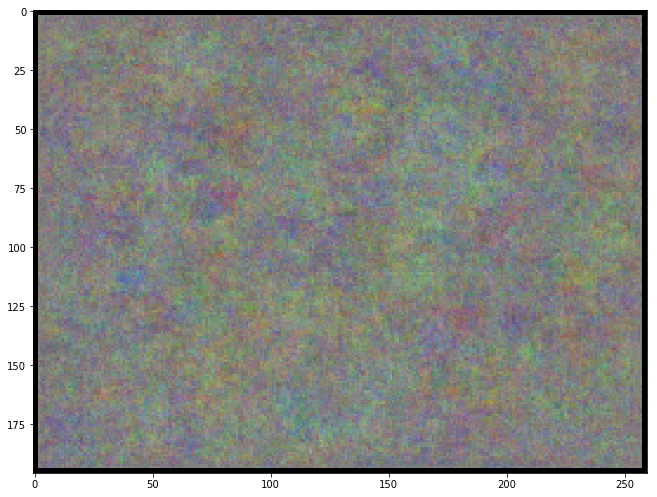

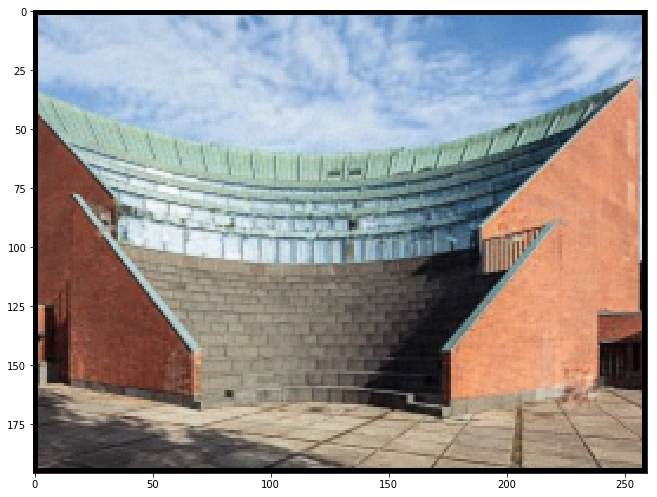

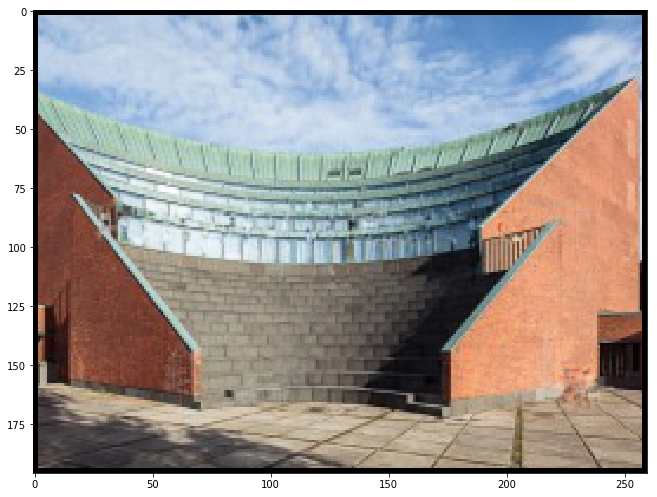

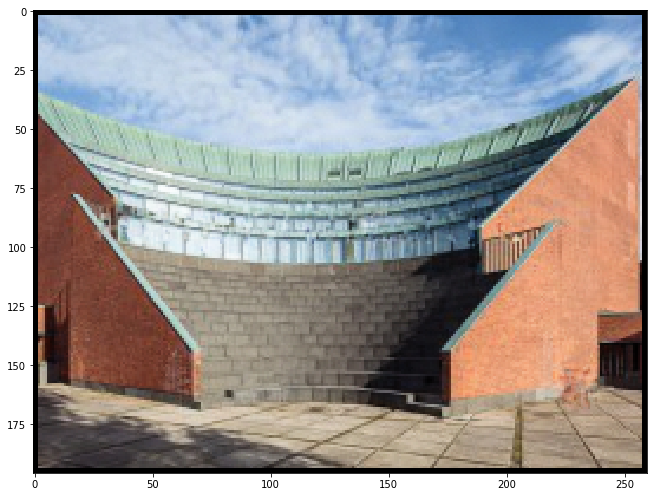

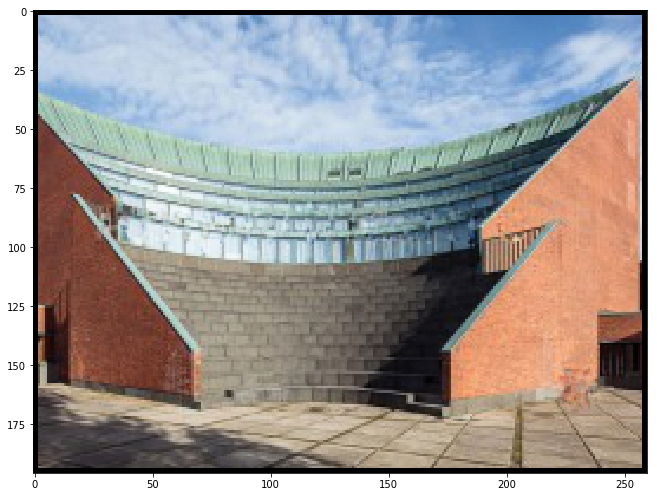

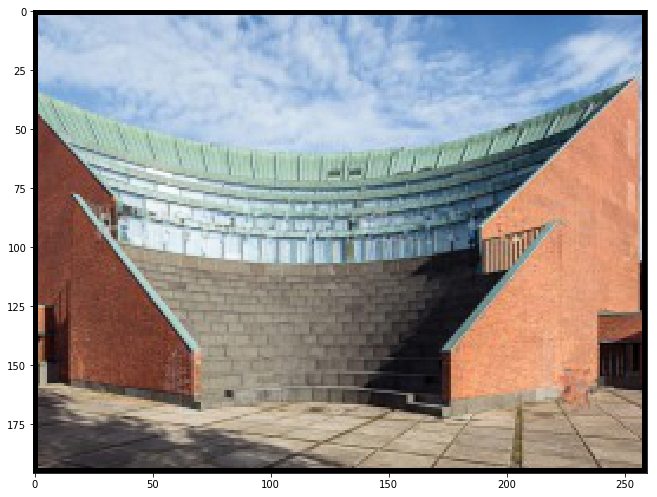

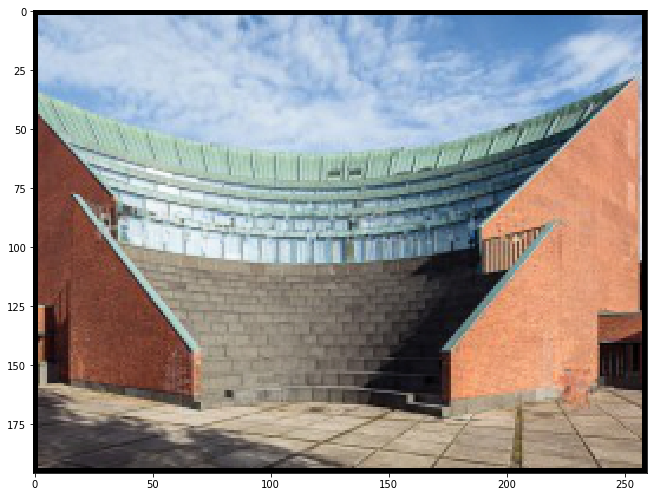

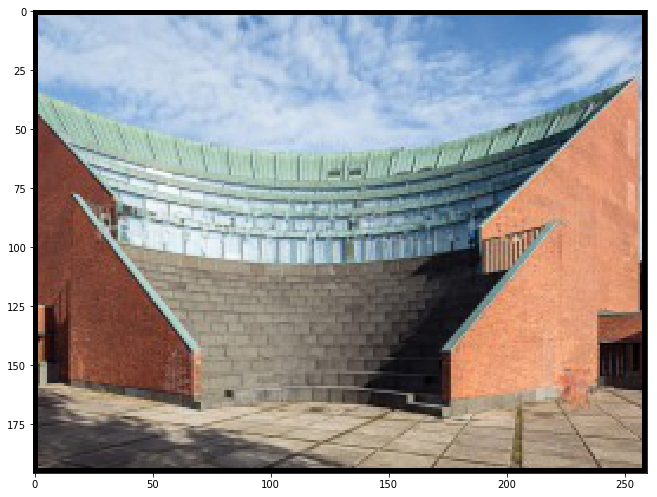

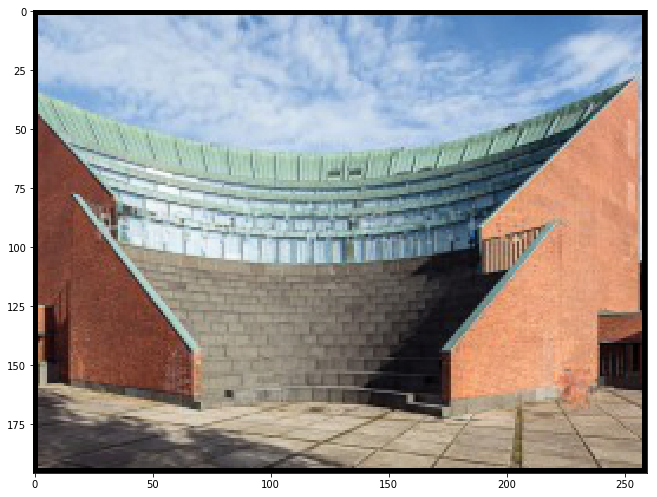

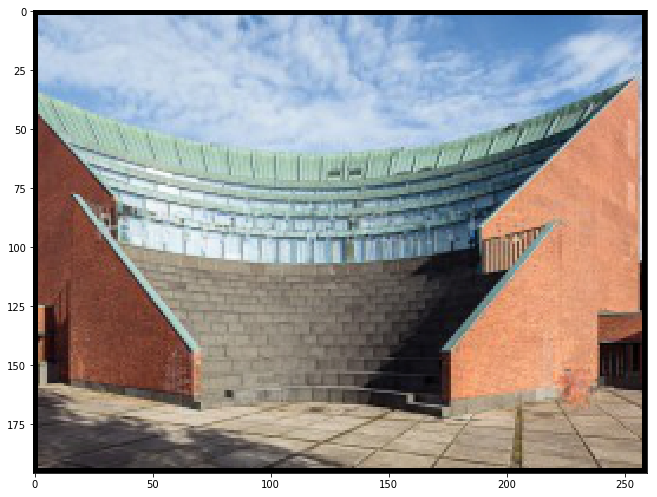

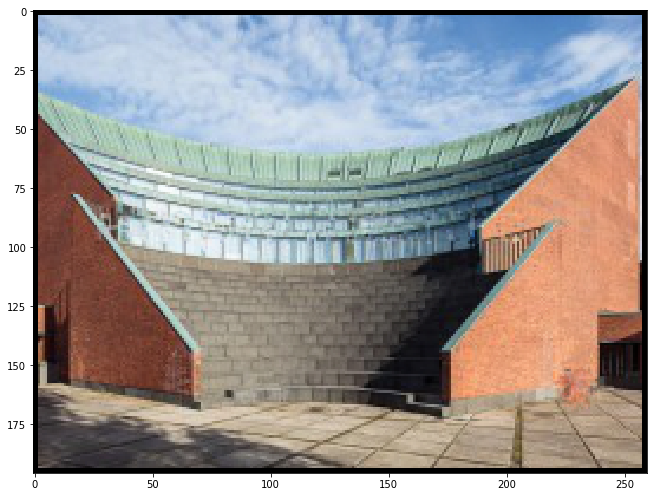

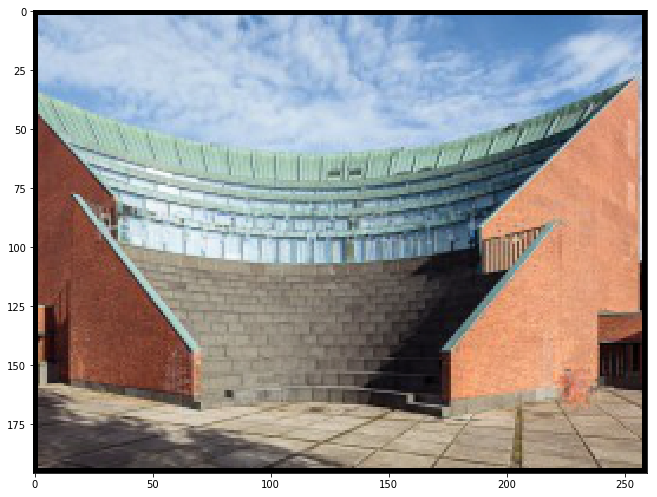

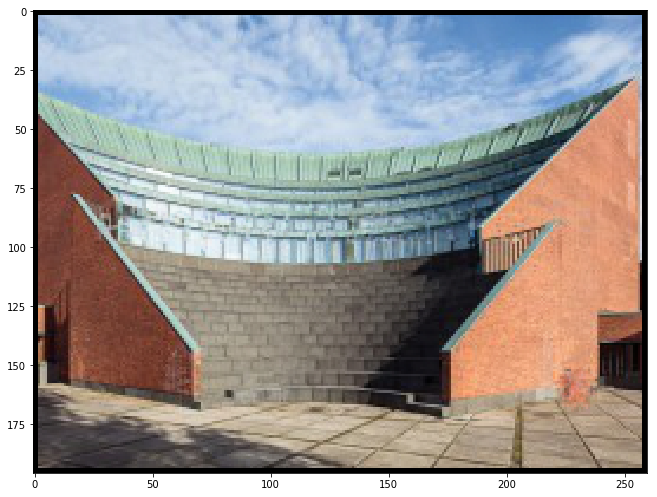

In [9]:
print('Starting optimization with ADAM')
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
        
for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

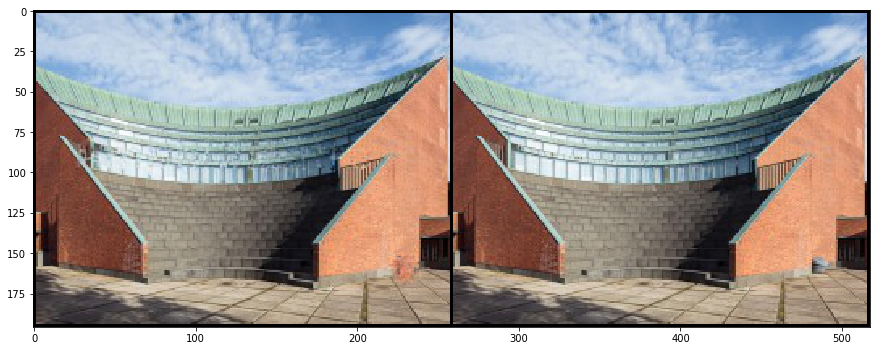

In [10]:
out_np = utils.var_to_np(net(net_input))
utils.plot_image_grid([out_np, img_np], factor=13);

In [11]:
data = {}
data['psnr_history'] = psnr_history
pickle.dump(data, open('inpainting-large-skip_psnr.p','wb'))